In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_parquet("data/final/")
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dayofweek,trip_hour,is_peak_hour
0,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,19,1
1,2,1,-73.969276,40.797779,-73.922470,40.760559,0,1551,7,7,1
2,2,1,-73.982651,40.763840,-74.002228,40.732990,0,1274,3,22,0
3,2,2,-73.962982,40.756680,-73.984406,40.760719,0,1114,6,9,1
4,2,1,-73.992195,40.727226,-73.974655,40.783070,0,1414,6,0,0


In [ ]:
features=["vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag", 
    "trip_dayofweek", "trip_hour", "is_peak_hour"]
target = ["trip_duration"]

In [7]:
X= df[features]
y= df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["passenger_count", "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude", "trip_dayofweek", "trip_hour", "is_peak_hour"]),
        ('cat', OneHotEncoder(), ["vendor_id", "store_and_fwd_flag"])    
    ]
)

In [10]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', LinearRegression())
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

In [13]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Means Squared Error: {rmse_lr}")

Root Means Squared Error: 3610.0332300921737


In [22]:
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)

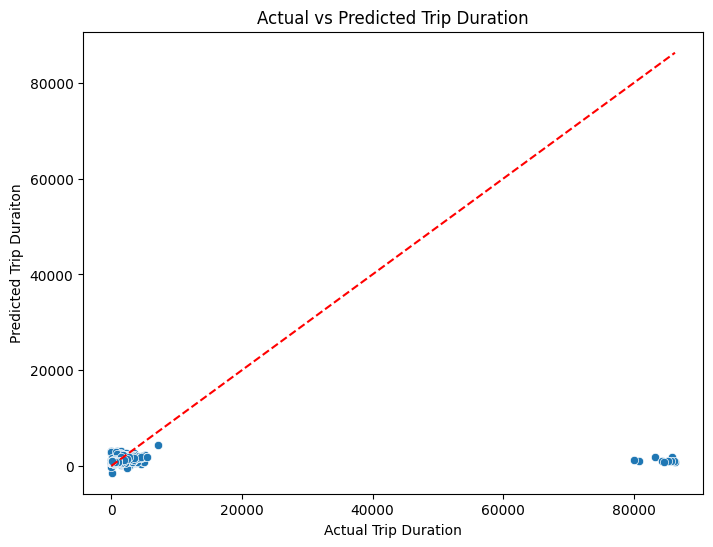

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_flat, y= y_pred_flat)
plt.plot([0,max(y_test_flat)], [0, max(y_test_flat)], color = 'red', linestyle = '--')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duraiton')
plt.title('Actual vs Predicted Trip Duration')
plt.show()

In [24]:
df['trip_duration'].describe()

count    30030.000000
mean       931.572028
std       2955.087133
min          2.000000
25%        394.000000
50%        659.000000
75%       1070.000000
max      86357.000000
Name: trip_duration, dtype: float64

Here we can see that our RMSE is near to 3500 means the values indicate the outliers are present. we need to handle the outlier and retrain the model

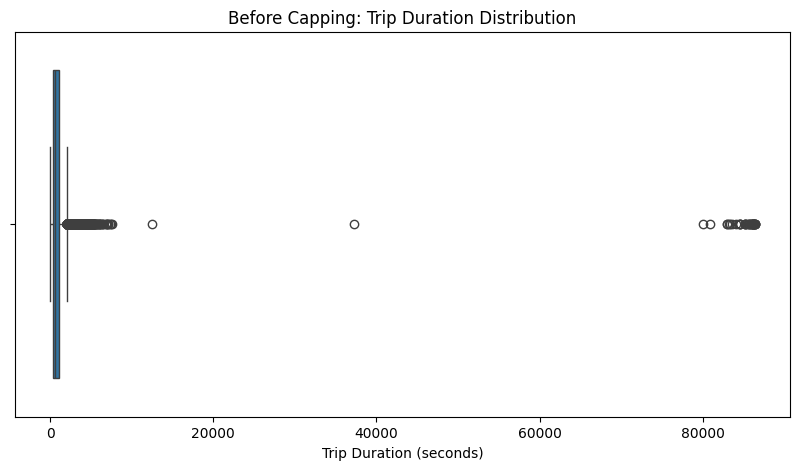

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['trip_duration'])
plt.title("Before Capping: Trip Duration Distribution")
plt.xlabel("Trip Duration (seconds)")
plt.show()

In [26]:

# Set upper limit at 99.5th percentile
upper_limit = df['trip_duration'].quantile(0.995)

# Cap the extreme values
df['trip_duration'] = np.where(df['trip_duration'] > upper_limit, upper_limit, df['trip_duration'])

print(f"Capped all trip durations above {upper_limit:.2f} seconds.")

Capped all trip durations above 4109.56 seconds.


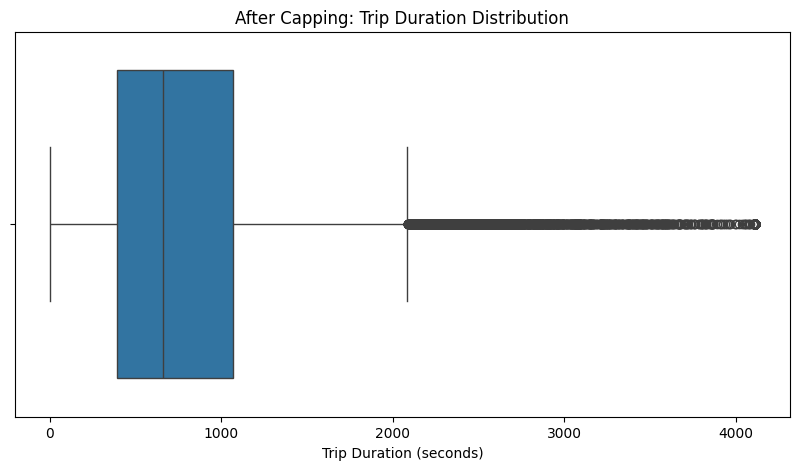

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['trip_duration'])
plt.title("After Capping: Trip Duration Distribution")
plt.xlabel("Trip Duration (seconds)")
plt.show()

In [28]:
features = [
    "vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag", 
    "trip_dayofweek", "trip_hour", "is_peak_hour"
]
target = "trip_duration"

X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["passenger_count", "pickup_longitude", "pickup_latitude", 
                                   "dropoff_longitude", "dropoff_latitude", "trip_dayofweek", "trip_hour", "is_peak_hour"]),
        ('cat', OneHotEncoder(), ["vendor_id", "store_and_fwd_flag"])
    ])

# Model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Fit model
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Root Mean Squared Error (After Capping): {rmse:.2f}")

✅ Root Mean Squared Error (After Capping): 580.37


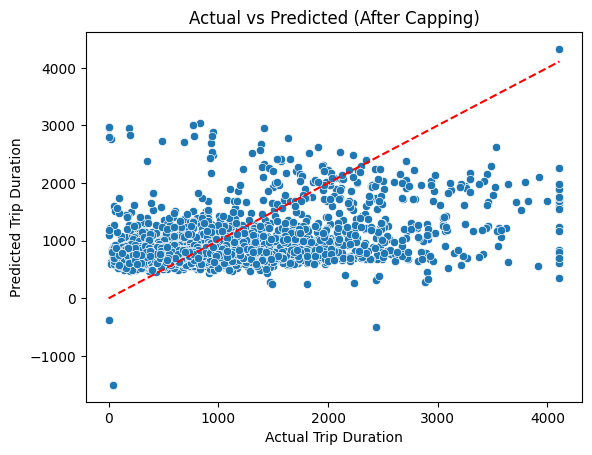

In [31]:
import seaborn as sns

sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted (After Capping)')
plt.show()

In [51]:
import mlflow
import mlflow.sklearn
mlflow.end_run()

In [52]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

mlflow.start_run()

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'model__alpha':[0.1, 1, 10, 100, 1000]
}

gridsearch_cv_ridge = GridSearchCV(estimator= ridge_pipeline, param_grid= param_grid, cv = 5, scoring= 'neg_mean_squared_error')

gridsearch_cv_ridge.fit(X_train, y_train)

best_estimator = gridsearch_cv_ridge.best_estimator_
y_pred_ridge = best_estimator.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

best_alpha = gridsearch_cv_ridge.best_params_['model__alpha']

print(f'RMSE for Ridge:{rmse_ridge}')
print(f'best alpha for Ridge: {best_alpha}')
mlflow.log_param("Model", "Ridge Regressor")
mlflow.log_param("RMSE", rmse_ridge)
mlflow.log_param("alphs", best_alpha)
mlflow.sklearn.log_model(best_estimator, artifact_path = "ridge_model")
mlflow.end_run()

2025/07/13 18:22:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE for Ridge:580.3559863938328
best alpha for Ridge: 10


2025/07/13 18:22:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [53]:
mlflow.end_run()

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]
)

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split':[2,5]
}
if mlflow.active_run():
    mlflow.end_run()
else:
    mlflow.start_run()
gridsearch_cv_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv = 5, scoring='neg_mean_squared_error', n_jobs= -1)

gridsearch_cv_rf.fit(X_train, y_train)
best_estimator = gridsearch_cv_rf.best_estimator_
y_pred_rf = best_estimator.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
best_params = gridsearch_cv_rf.best_params_
print(f'best Parameteres: {best_params}')
print(f"RMSE: {rmse_rf}")
mlflow.log_param("Model", "RandomForestRegressor")
mlflow.log_param("Best Estimator", gridsearch_cv_rf.best_params_['model__n_estimators'])
mlflow.log_param("RMSE", rmse_rf)
mlflow.log_param('Max Depth', gridsearch_cv_rf.best_params_['model__max_depth'])
mlflow.sklearn.log_model(best_estimator, "RandomForestModel")

2025/07/13 18:30:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


best Parameteres: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 300}
RMSE: 342.69230650599854


2025/07/13 18:30:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [56]:
mlflow.end_run()

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
with mlflow.start_run():
    gb_pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]
    )

    param_grid_gb = {
        "model__n_estimators":[100, 200, 300],
        "model__learning_rate":[0.01, 0.1, 0.5],
        "model__max_depth":[3, 5, 7]
    }

    gridsearch_cv_gb = GridSearchCV(estimator=gb_pipeline, param_grid= param_grid_gb, cv = 5, scoring='neg_mean_squared_error', n_jobs =-1)

    gridsearch_cv_gb.fit(X_train, y_train)

    best_estimator = gridsearch_cv_gb.best_estimator_

    y_pred_gb = best_estimator.predict(X_test)
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    print(f"RMSE: {rmse_gb}")
    mlflow.log_param("Model", "Gradient Boosting Regressor")
    mlflow.log_param('best_estimator', gridsearch_cv_gb.best_params_['model__n_estimators'])
    mlflow.log_param('best max depth ', gridsearch_cv_gb.best_params_['model__max_depth'])
    mlflow.log_param('best learning paramter ', gridsearch_cv_gb.best_params_['model__learning_rate'])
    mlflow.sklearn.log_model(best_estimator, "Gradient Boosting Model")

2025/07/13 18:35:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE: 343.0568476901408


2025/07/13 18:35:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [59]:
logged_model = f"runs:/36635bca67554be6ba088c23e39304e4/RandomForestModel"
model = mlflow.sklearn.load_model(logged_model)
import joblib
joblib.dump(model, "model/random_forest_model.pkl")
print("model saved to model/random_forest_model.pkl")


model saved to model/random_forest_model.pkl
